# Localization of the Regions

In this notebook we find different plots of the regions in which we focus the studies. We find the MLD climatology for March, over the entire North Atlantic Ocean. The dataset considered here are the ARMOR3D and ISAS, including all its versions. 
The versions of ISAS refer to the different criteria consiered to estimate the MLD. Is a fixed density criteria. These are: 0.03, 0.015 and 0.046 kg/m3.

The regions considered are: the Gulf Stream, Labrador, Irminger and North Eastern seas. We have small regions over which time series for all datasets are calculated (in the TimeSeries notebook) and large regions over which are performed animations, PDFs, and Seasonal cycle analysis (Animation, Histograms, peak-to-peak notebooks) and others.

In [1]:
#########################
######### ROUTINE TO PLOT THE SEASONAL MEAN OF ANY VARIABLE OVER AN ALREADY 
######### SELECTED REGION.
#########################

import cartopy

import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

import datetime
import pandas

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#########################
######### DICTIONARIES DEFINITION 
#########################

Range_MLD = {
    'Mar' : {
        'vmin' : 160, 
        'vmax' : 1800},
    'Sep' : {
        'vmin' : 18, 
        'vmax' : 180},
}


#Colorbar parameters
color_bar = {
    'cmap' : 'YlGnBu',
    'orientation' : 'vertical',
    'title_cbr' : 'depth [m]'
}


# Coordinates for small regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
reg = {
    'lab': {
        'lon' : (-55, -51),
        'lat' : (56, 59),
        'name' : 'Labrador Sea'
    },
    'irm': {
        'lon' : (-39, -35),
        'lat' : (58, 61),
        'name' : 'Irminger Sea'
    },
    'gul': {
        'lon' : (-57, -53),
        'lat' : (34, 38),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-20, -16),
        'lat' : (50, 53),
        'name' : 'North East Sea'
    }
}



# Coordinates for large regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'noa':{
        'lon' : (-90, 50),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}

In [128]:
def Times(data):
    dat = data.time.values
    dat = pandas.to_datetime(dat, format='%y')
    month = dat.strftime('%b')
    year = dat.strftime('%Y')
    day =  dat.strftime('%d')
    
    return(month, year, day)


def Params(dic, var):
    if(dic['cmap']==None):
        dic['cmap'] = 'magma'
        
    if(dic['orientation']==None):
        dic['orientation'] = 'vertical'
    
    if(dic['title_cbr']==None):
        dic['title_cbr'] = str(var.long_name)
    return(dic)


def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


def Axes_sel(Ncols, axs, i, j):
    if (Ncols == 1):
            ax = axs[i]
    else:
            ax = axs[i,j]
    return(ax)


def Reg_delimitation(ax, *corner, w, h, fill=False, color=None, alpha=None):
    """
        Reg_delimitation is a function that draws a rectangle
        of a region over a map projection. 

        Parameters:
        ------------
        ax : axes
            Current axes object in which is drawn the rectangle.

        corner : (float, float)
            Pair of coordinates for the lower left point of the
            rectangle. corner=(x,y)

        w : float
            Number of degrees for width of rectangle.

        h : float
            Number of degrees for rectangle height. 
        
        fill : Boolean
            Decide if the rectangle is filled or not.
        
        color : string
            Color fill 
        
        alpha : float
            Opacity of the rectangle's filling
            
    """
    import matplotlib.patches as mpatches
    ax.add_patch(mpatches.Rectangle(xy=[*corner], width=w, height=h,
                                    fill=fill,
                                    facecolor=color,
                                    alpha=alpha,
                                    transform=ccrs.PlateCarree()
                                   )
                )
                     


    
def Map(ax, region, xtick, ytick):
    """
        Map is a function that helps to plot the map on a certain projection
        of a region. It always uses 50m definition of coastlines.

        Parameters:
        ------------
        ax : axes
            Current axes object in which is drawn the map.

        region : list
            Set of limit coordinates of the region to plot.
            It has the shape [lon1, lon2, lat1, lat2]

        xtick : np.array
            array containing the number and spacement of ticks 
            in x-axis.

        ytick : np.array
            Array containing the number and spacement of ticks 
            in y-axis.
    """
    ax.set_global()
    ax.coastlines('50m')
    ax.set_xticks(xtick, crs=ccrs.PlateCarree())
    ax.set_yticks(ytick, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(region, crs=ccrs.PlateCarree())     #lat, lon
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
                 color='gray', alpha=0.5, linestyle='-.')


    
## Need to make this a little bit more general, also in the extend. by now extends just to max
def Plot_2D(data_set, reg, *cm_levs, cmap=None, cont_line=False, nlines=None):
    """
        Plot_2D is a function that plots a 2D variable using a
        colormap over a spatial region. It makes use of the external 
        functions 'Grid' and 'Map'. It also makes use of the dictionary 
        'reg_ext', to get the spatial delimitations. This works only
        for DataArray type and to plot MLD. The pre-defined cmap is 
        'magma_r'.
        
        Parameters:
        ------------
        data_set : DataArray
            Current axes object in which is drawn the map. It can
            be a complete DataArray, or just the values for one of
            the variables.
            
        reg : string
            Abreviation name that identifies the region in 
            which the plot is being done. It must be defined
            inside the dictionary 'reg_ext'.
            
        cm_levs : tuple, integers
            It contains the parameters for the color bar. The 
            order is: minimum, maximum, #of levels
        
        cmap : String
            Name of the color map to use. Default is 'magma_r'
            
        cont_line : Boolean
            If True we allow to plot a second contour plot of SSH. 
            On top of the MLD heat map.
            If False, this function plots a heat map of the variable 
            set by parameter 'data_set'.
            
        nlines : integers
            Is the number of lines to plot the contour plot. It is 
            optional, and is necessary when cont_line=True.
        
        Output:
        ------------
        ax : axes
    """
    
    # Shaping the plot
    x_n, y_n = Grid(data_set)
    projection = ccrs.PlateCarree(360)
    
    # Getting the delimitations and ticks
    lon1, lon2 = reg_ext[reg]['lon']
    lat1, lat2 = reg_ext[reg]['lat']
    xtick = np.linspace(lon1, lon2, num=9)
    ytick = np.linspace(lat1, lat2, num=4)
    region = [lon1, lon2, lat1, lat2]    #Lon, Lat
    
    # If we want to plot MLD and SSH, or other thing, without SSH countours
    if cont_line:
        variable = data_set.mlotst
    else:
        variable = data_set
        
    if not cmap:
        cmap = 'plasma_r'

    # Start of the plot
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(10,5))    
    
    Map(ax, region, xtick, ytick)
    
    # Here plot the variable using a heat map, defining also color bar
    contr1 = ax.contourf(x_n, y_n, variable, 
                         levels=np.linspace(cm_levs[0], cm_levs[1], cm_levs[2]),
                         cmap=cmap, extend='max')
    cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                        label='MLD [m]', extend='both')  
    # Here adding an extra layer of SSH at surface using countour lines
    if cont_line:
        contr2 = ax.contour(x_n, y_n, data_set.zo[0], nlines, linewidths=0.5, colors='k')
    
    # Saving the figure
    ##if save:
    ##    fig.savefig(os.path.abspath(os.path.sep.join([".","dummy_images","Noe_%0.4d.png" % it])))

    return(ax)
    

In [111]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################


## Opening datasets
dir_1 = '../../data_ARMOR/'
dir_2 = '/net/alpha/exports/sciences/data/LPO_ISAS/ANA_ISAS15/fld2D/'


fl_n1 = 'ARMOR_*.nc'
fl_n2 = 'ISAS15_DM_2006_2015_MLDS.nc'
fl_n3 = 'ISAS15_DM_2002_2015_MLDS_0.03.nc'
fl_n4 = 'ISAS15_DM_2002_2015_MLDS_0.015.nc'
fl_n5 = 'ISAS15_DM_2002_2015_MLDS_0.046.nc'

c_armor = xr.open_mfdataset(dir_1 + fl_n1)
c_isas = xr.open_dataset(dir_2 + fl_n2, autoclose=True)
c_isas2 = xr.open_dataset(dir_2 + fl_n3, autoclose=True)
c_isas3 = xr.open_dataset(dir_2 + fl_n4, autoclose=True)
c_isas4 = xr.open_dataset(dir_2 + fl_n5, autoclose=True)

## Taking just MLD from the datasets
mld_i = c_isas.MLDP
mld_i2 = c_isas2.MLDP
mld_i3 = c_isas3.MLDP
mld_i4 = c_isas4.MLDP
mld_a = c_armor.mlotst

## Climatology
month_a = mld_a.groupby('time.month').mean('time')
month_i = mld_i.groupby('time.month').mean('time')
month_i2 = mld_i2.groupby('time.month').mean('time')
month_i3 = mld_i3.groupby('time.month').mean('time')
month_i4 = mld_i4.groupby('time.month').mean('time')

/venv/py3-phyocean/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

/venv/py3-phyocean/lib/python3.6/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/venv/py3-phyocean/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: The autoclose argument is no longer u

In [112]:
## Making lists of the names and dataarrays to plot
## The names are for the title of the figure

data_sets = [month_a.sel(month=3), month_i.sel(depth=1,month=3),
             month_i2.sel(depth=1, month=3), month_i3.sel(depth=1, month=3),
             month_i4.sel(depth=1, month=3)]

names = ['ARMOR-3D', 'ISAS-original', 'ISAS-003',
         'ISAS-0015', 'ISAS-0046']

## Chosing the limits of the colorbar
month = 'Mar'
vmin = Range_MLD[month]['vmin']
vmax = Range_MLD[month]['vmax']

In [113]:
## Left-down point of the regions
# c_n :: for the small regions
# ce_n :: for the large regions

c_1 = (-57, 34) # Gulf Stream
ce_1 = (-75, 30)

c_2 = (-39, 58) # Irminger
c_3 = (-55, 56) # Labrador
ce_23 = (-60, 50)

c_4 = (-20, 50) # Northe East
ce_4 = (-30, 45)

## ARMOR-3D

/venv/py3-phyocean/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


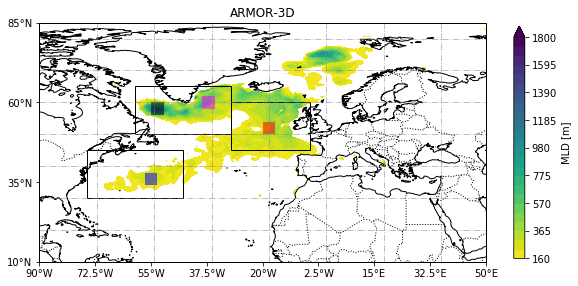

In [123]:
cm_levs = (vmin, vmax, 25)
ax = Plot_2D(data_sets[0], 'noa', *cm_levs, cmap='viridis_r',cont_line=False, nlines=None)

Reg_delimitation(ax, *c_1, w=4, h=4, fill=True, color='blue', alpha=0.55)
Reg_delimitation(ax, *ce_1, w=30, h=15, fill=False)

Reg_delimitation(ax, *c_2, w=4, h=4, fill=True, color='magenta', alpha=0.55)
Reg_delimitation(ax, *c_3, w=4, h=4, fill=True, color='k', alpha=0.55)
Reg_delimitation(ax, *ce_23, w=30, h=15, fill=False)

Reg_delimitation(ax, *c_4, w=4, h=4, fill=True, color='red', alpha=0.55)
Reg_delimitation(ax, *ce_4, w=25, h=15, fill=False)

ax.set_title(names[0])
plt.show()
#plt.savefig(name, bbox_inches='tight')

## ISAS-original

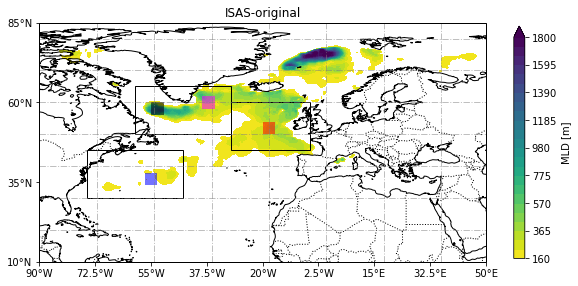

In [124]:
cm_levs = (vmin, vmax, 25)
ax = Plot_2D(data_sets[1], 'noa', *cm_levs, cmap='viridis_r',cont_line=False, nlines=None)

Reg_delimitation(ax, *c_1, w=4, h=4, fill=True, color='blue', alpha=0.55)
Reg_delimitation(ax, *ce_1, w=30, h=15, fill=False)

Reg_delimitation(ax, *c_2, w=4, h=4, fill=True, color='magenta', alpha=0.55)
Reg_delimitation(ax, *c_3, w=4, h=4, fill=True, color='k', alpha=0.55)
Reg_delimitation(ax, *ce_23, w=30, h=15, fill=False)

Reg_delimitation(ax, *c_4, w=4, h=4, fill=True, color='red', alpha=0.55)
Reg_delimitation(ax, *ce_4, w=25, h=15, fill=False)

ax.set_title(names[1])
plt.show()
#plt.savefig(name, bbox_inches='tight')

## ISAS-0.03

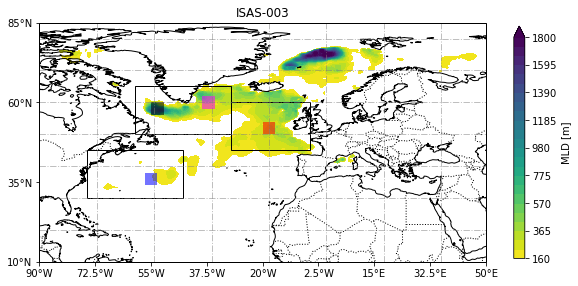

In [125]:
cm_levs = (vmin, vmax, 25)
ax = Plot_2D(data_sets[2], 'noa', *cm_levs, cmap='viridis_r',cont_line=False, nlines=None)

Reg_delimitation(ax, *c_1, w=4, h=4, fill=True, color='blue', alpha=0.55)
Reg_delimitation(ax, *ce_1, w=30, h=15, fill=False)

Reg_delimitation(ax, *c_2, w=4, h=4, fill=True, color='magenta', alpha=0.55)
Reg_delimitation(ax, *c_3, w=4, h=4, fill=True, color='k', alpha=0.55)
Reg_delimitation(ax, *ce_23, w=30, h=15, fill=False)

Reg_delimitation(ax, *c_4, w=4, h=4, fill=True, color='red', alpha=0.55)
Reg_delimitation(ax, *ce_4, w=25, h=15, fill=False)

ax.set_title(names[2])
plt.show()
#plt.savefig(name, bbox_inches='tight')

## ISAS-0.015

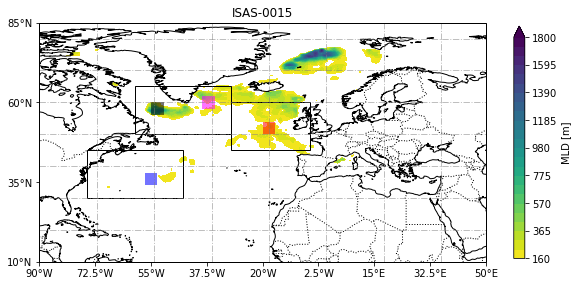

In [126]:
cm_levs = (vmin, vmax, 25)
ax = Plot_2D(data_sets[3], 'noa', *cm_levs, cmap='viridis_r',cont_line=False, nlines=None)

Reg_delimitation(ax, *c_1, w=4, h=4, fill=True, color='blue', alpha=0.55)
Reg_delimitation(ax, *ce_1, w=30, h=15, fill=False)

Reg_delimitation(ax, *c_2, w=4, h=4, fill=True, color='magenta', alpha=0.55)
Reg_delimitation(ax, *c_3, w=4, h=4, fill=True, color='k', alpha=0.55)
Reg_delimitation(ax, *ce_23, w=30, h=15, fill=False)

Reg_delimitation(ax, *c_4, w=4, h=4, fill=True, color='red', alpha=0.55)
Reg_delimitation(ax, *ce_4, w=25, h=15, fill=False)

ax.set_title(names[3])
plt.show()
#plt.savefig(name, bbox_inches='tight')

## ISAS-0.046

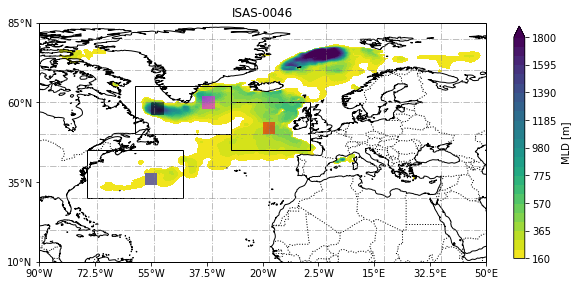

In [127]:
cm_levs = (vmin, vmax, 25)
ax = Plot_2D(data_sets[4], 'noa', *cm_levs, cmap='viridis_r',cont_line=False, nlines=None)

Reg_delimitation(ax, *c_1, w=4, h=4, fill=True, color='blue', alpha=0.55)
Reg_delimitation(ax, *ce_1, w=30, h=15, fill=False)

Reg_delimitation(ax, *c_2, w=4, h=4, fill=True, color='magenta', alpha=0.55)
Reg_delimitation(ax, *c_3, w=4, h=4, fill=True, color='k', alpha=0.55)
Reg_delimitation(ax, *ce_23, w=30, h=15, fill=False)

Reg_delimitation(ax, *c_4, w=4, h=4, fill=True, color='red', alpha=0.55)
Reg_delimitation(ax, *ce_4, w=25, h=15, fill=False)

ax.set_title(names[4])
plt.show()
#plt.savefig(name, bbox_inches='tight')